### Initial playground for domain adaptation and moving into active learning

* Paul Blankley 

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import src.active_learning as al

import importlib as imp
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch 
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import pyro

%matplotlib inline

In [160]:
al = imp.reload(al)

In [2]:
######## SET PARAMS ##########
batch_size = 8
start_size = 64

##############################

# Get raw datasets 
train_set = dset.MNIST(root='./data', train=True, transform=transforms.ToTensor(),download=False)
test_set = dset.MNIST(root='./data', train=False, transform=transforms.ToTensor())

# Get loaders and initial indices
loaders, init_idx, unlab_idx = al.setup_data_loaders(batch_size=batch_size, starting_size=start_size,\
                                                     use_cuda=False)
train_loader, unlab_loader, val_loader, test_loader = loaders

In [3]:
# Get x/y split for the validation and test sets 
val_x,val_y = al.get_xy_split(val_loader)
test_x,test_y = al.get_xy_split(test_loader)


### Idea:

You start with 64 random points to make a model. Then you get to choose 16 points to have the labels given to you.  Just pass a policy function that decides which policy to follow to get the new points.  Then compare the two policies and show that the "active learning" (with intelligent policy performs better).

In [156]:
def train_model(model, data_loader, loss_func, optimizer, epochs=10):
    """ Function to train the model """
    losses,itrs = [],0

    for epoch in range(epochs):
        for i,(batch_x,batch_y) in enumerate(data_loader):
            batch_x = Variable(batch_x)
            batch_y = Variable(batch_y)

            y_pred = model(batch_x)
            loss = loss_func(y_pred, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            itrs+=1
            losses.append(loss.data.numpy()[0])
            
    # For plotting 
    return list(range(itrs)), losses

def active_learn(model, base_data, train_idx, unlab_idx, policy, loss_func, optimizer, val_loader, \
                 epochs_per_train=10, points_per_itr=16, batch_size=8, meta_epochs=20):
    """ Active learning based on a specified policy. """
    # initialy train the model and then based on unlabeled results use the policy to choose more points ans iterate
    total_acc = []
    train_data, _ = al.get_dataloader(train_idx, [], base_data, batch_size=batch_size)
    unlab_data, _ = al.get_dataloader(unlab_idx, [], base_data, batch_size=len(unlab_idx))
    val_x, val_y = al.get_xy_split(val_loader)
    
    for e in tqdm(range(meta_epochs)):
        # Train the model
        itr, losses = train_model(model, train_data, loss_func, optimizer, epochs=epochs_per_train)
        
        # Get the next points to label and add to training 
        new_points = al.get_requested_points(model, unlab_data, unlab_idx, policy=policy, \
                                             num_points=points_per_itr)
        
        # Get the new DataLoaders based on the selection of the points 
        train_data, train_idx = al.get_dataloader(train_idx, new_points, base_data, batch_size=batch_size)
        unlab_idx = list(set(unlab_idx)-set(new_points))
        unlab_data, unlab_idx = al.get_dataloader(unlab_idx, [], base_data, batch_size=len(unlab_idx))
        
        # Get accuracy of the model 
        total_acc.append(al.accuracy(model,val_x,val_y))
        
    return list(range(meta_epochs)), total_acc


def random_policy(unlab_preds, unlab_idx, num_points):
    return np.random.choice(unlab_idx, size=num_points, replace=False)

def boundary_policy(unlab_preds, unlab_idx, num_points):
    args_boundary = al.boundary_proximity(unlab_preds, num_points)
    policy_idxs = np.array([unlab_idx[i] for i in args_boundary])
    return policy_idxs


def even_policy(unlab_preds, unlab_idx, num_points):
    cut = num_points%10
    times = num_points//10
    _,preds = torch.max(unlab_preds,dim=1)
    output = []
    for res in range(10):
        if res<cut:
            output.extend(np.random.choice([idx for idx, elm in enumerate(preds) \
                                            if elm.data.numpy()[0] == res], size=times+1))
        else:
            output.extend(np.random.choice([idx for idx, elm in enumerate(preds) \
                                            if elm.data.numpy()[0] == res], size=times))
    return np.array(output)


In [157]:
# Define the model
class logreg(nn.Module):
    """ Logistic regression """
    def __init__(self, classes):
        super(logreg, self).__init__()
        self.classes = classes
        self.w = nn.Linear(28*28,classes)
        
    def forward(self, x):
        x = self.w(x.view(-1,1,28*28))
        return nn.functional.log_softmax(x.view(-1,self.classes),dim=1)


model_rand = logreg(classes=10)
model_bound = logreg(classes=10)
model_even = logreg(classes=10)
loss_func = nn.NLLLoss()
optimizer_rand = optim.SGD(model_rand.parameters(), lr=.01)
optimizer_bound = optim.SGD(model_bound.parameters(), lr=.01)
optimizer_even = optim.SGD(model_even.parameters(), lr=.01)

# plot_itr, plot_loss = train_model(model_rand, train_loader, loss_func, optimizer)

In [ ]:
random_iters, random_acc = [],[]
for i in range(10):
    model_rand = logreg(classes=10)
    optimizer_rand = optim.SGD(model_rand.parameters(), lr=.01)
    rand_itrs, rand_acc = active_learn(model_rand, train_set, init_idx, unlab_idx, random_policy, loss_func, \
                                   optimizer_rand, val_loader, epochs_per_train=5, points_per_itr=10, \
                                   batch_size=8, meta_epochs=25)
    random_iters.append(rand_itrs)
    random_acc.append(rand_acc)
print('Active Learning with random policy done!')


A Jupyter Widget

In [166]:
boundary_iters, boundary_acc = [],[]
for i in range(10):
    model_bound = logreg(classes=10)
    optimizer_bound = optim.SGD(model_bound.parameters(), lr=.01)
    bound_itrs, bound_acc = active_learn(model_bound, train_set, init_idx, unlab_idx, boundary_policy, loss_func, \
                                   optimizer_bound, val_loader, epochs_per_train=5, points_per_itr=10, \
                                   batch_size=8, meta_epochs=25)
    boundary_iters.append(bound_itrs)
    boundary_acc.append(bound_acc)
print('Active Learning with boundary policy done!')


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Active Learning with boundary policy done!


In [167]:
evenp_iters, evenp_acc = [],[]
for i in range(10):
    model_even = logreg(classes=10)
    optimizer_even = optim.SGD(model_even.parameters(), lr=.01)
    even_itrs, even_acc = active_learn(model_even, train_set, init_idx, unlab_idx, boundary_policy, loss_func, \
                                   optimizer_even, val_loader, epochs_per_train=5, points_per_itr=10, \
                                   batch_size=8, meta_epochs=25)
    evenp_iters.append(even_itrs)
    evenp_acc.append(even_acc)
print('Active Learning with boundary policy done!')


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Active Learning with boundary policy done!


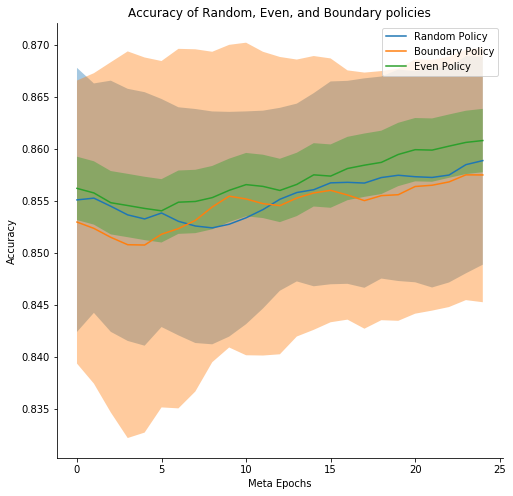

In [184]:
itrs = np.array(random_iters[0])
ra = np.mean(random_acc, axis=0)
ba = np.mean(boundary_acc, axis=0)
ea = np.mean(evenp_acc, axis=0)
r_err = np.std(random_acc,axis=0)
b_err = np.std(boundary_acc,axis=0)
e_err = np.std(even_acc,axis=0)

plt.figure(figsize=(8,8))
plt.plot(itrs, ra, label="Random Policy")
plt.fill_between(itrs, ra+r_err, ra-r_err,alpha=0.4)
plt.plot(itrs, ba, label="Boundary Policy")
plt.fill_between(itrs, ba+b_err, ba-b_err,alpha=0.4)
plt.plot(itrs, ea, label="Even Policy")
plt.fill_between(itrs, ea+e_err, ea-e_err,alpha=0.4)
plt.title('Accuracy of Random, Even, and Boundary policies')
plt.xlabel('Meta Epochs')
plt.ylabel('Accuracy')
plt.legend()
sns.despine()

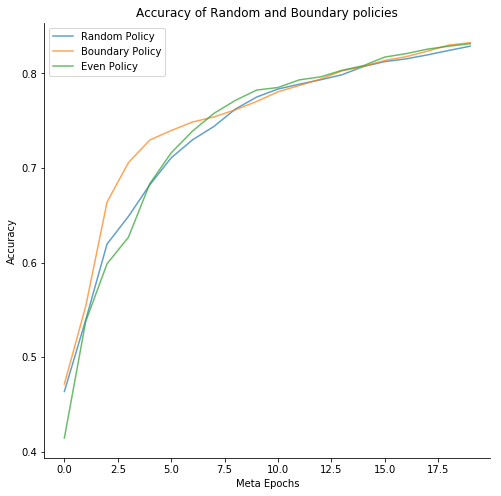

In [163]:
plt.figure(figsize=(8,8))
plt.plot(rand_itrs,rand_acc,label='Random Policy',alpha=0.7)
plt.plot(bound_itrs,bound_acc,label='Boundary Policy',alpha=0.7)
plt.plot(even_itrs,even_acc,label='Even Policy',alpha=0.7)
plt.title('Accuracy of Random and Boundary policies')
plt.xlabel('Meta Epochs')
plt.ylabel('Accuracy')
plt.legend()
sns.despine()

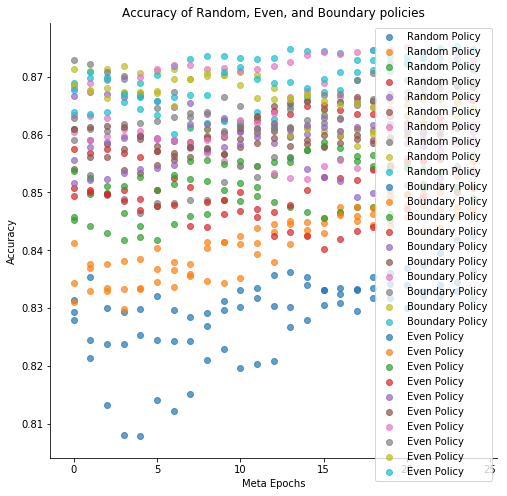

In [169]:
plt.figure(figsize=(8,8))

for x,y in zip(random_iters,random_acc):
    plt.scatter(x,y,label='Random Policy',alpha=0.7)
for x,y in zip(boundary_iters, boundary_acc):
    plt.scatter(x,y,label='Boundary Policy',alpha=0.7)
for x,y in zip(evenp_iters, evenp_acc):
    plt.scatter(x,y,label='Even Policy',alpha=0.7)
plt.title('Accuracy of Random, Even, and Boundary policies')
plt.xlabel('Meta Epochs')
plt.ylabel('Accuracy')
plt.legend()
sns.despine()

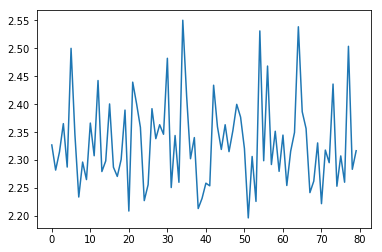

In [127]:
plt.plot(plot_itr,plot_loss)

In [32]:
acc_val = al.accuracy(model,val_x,val_y)
print('Accuracy on the validation set:',acc_val)

Accuracy on the validation set: 0.4834


In [7]:
print(model)

logreg(
  (w): Linear(in_features=784, out_features=10)
)
